# Camera Calibration

In [1]:
#Import needed Libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Chessboard
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )


## Visualize calibration

Text(0.5,1,'Undistorted Image')

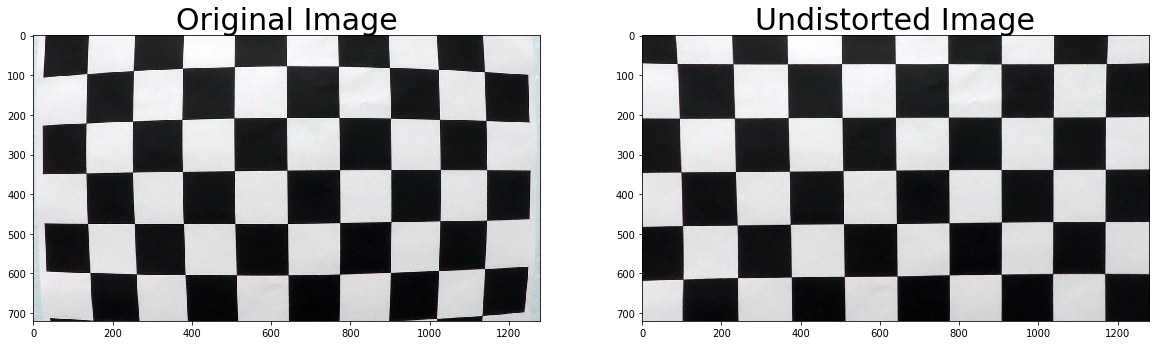

In [2]:
#Load calibration parameters previously found
with open('wide_dist_pickle.p', 'rb') as f:
    data = pickle.load(f)

dist = data['dist']
mtx =  data['mtx']

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

# Image warping

In [3]:
def warp(img, roi):
    '''This function takes as parameter the image to be transformed
        and the Region of Interest (roi).
        Roi must be a tuple (x1,x2,y1,y2)
    '''
    img_size=(img.shape[1], img.shape[0])
    
    #This values were chosen by looking at the pixels in an image editor.
    src=np.float32([
        [696,455],
        [1038,675],
        [280,675],
        [588,455]])
    
    dst=np.float32([
        [700,350],
        [700,700],
        [500,700],
        [500,350]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped[roi[2]:roi[3],roi[0]:roi[1]]

## Visualization of image warped

Text(0.5,1,'Warped Image')

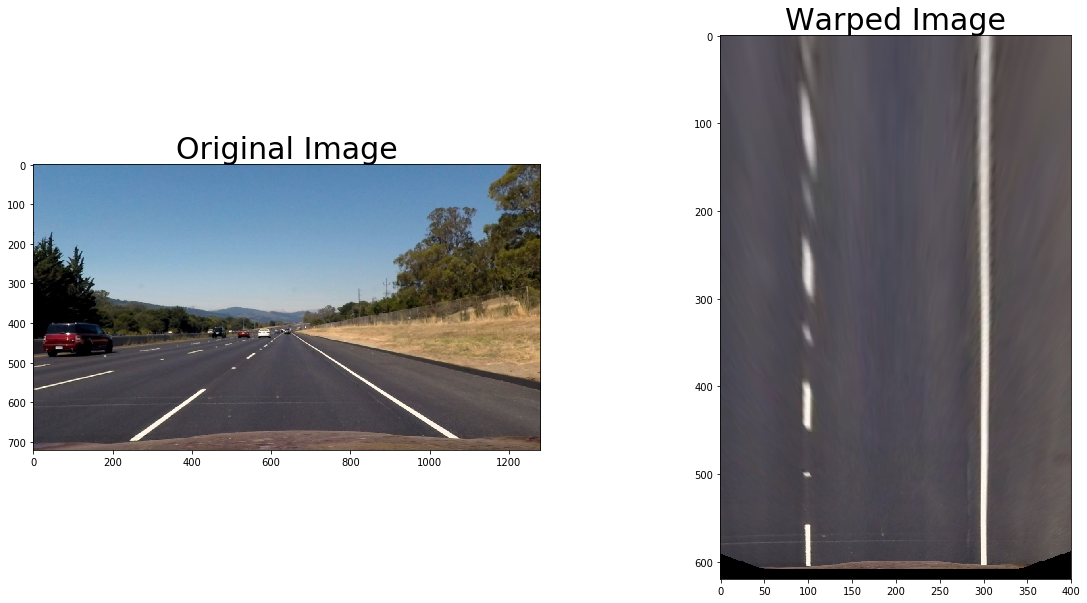

In [4]:
import matplotlib.image as mpimg

#Get Perspective transform
#Read image example
img = mpimg.imread('./test_images/straight_lines2.jpg')
#Undistort image
undist_test = cv2.undistort(img, mtx, dist, None, mtx)
#Choose roi to crop
roi = (400,800,100,img.shape[0])
warped_im=warp(undist_test, roi)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_im)
ax2.set_title('Warped Image', fontsize=30)

# Trhesholding

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def thresholding(img, s_thresh=(150, 210), sx_thresh=(40, 150)):
    img = np.copy(img)
    img_blur = gaussian_blur(img[:,:,0],9)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    #sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(img[:,:,0], cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return np.uint8((s_binary == 1) | (sxbinary == 1))
    

## Visualize thresholding

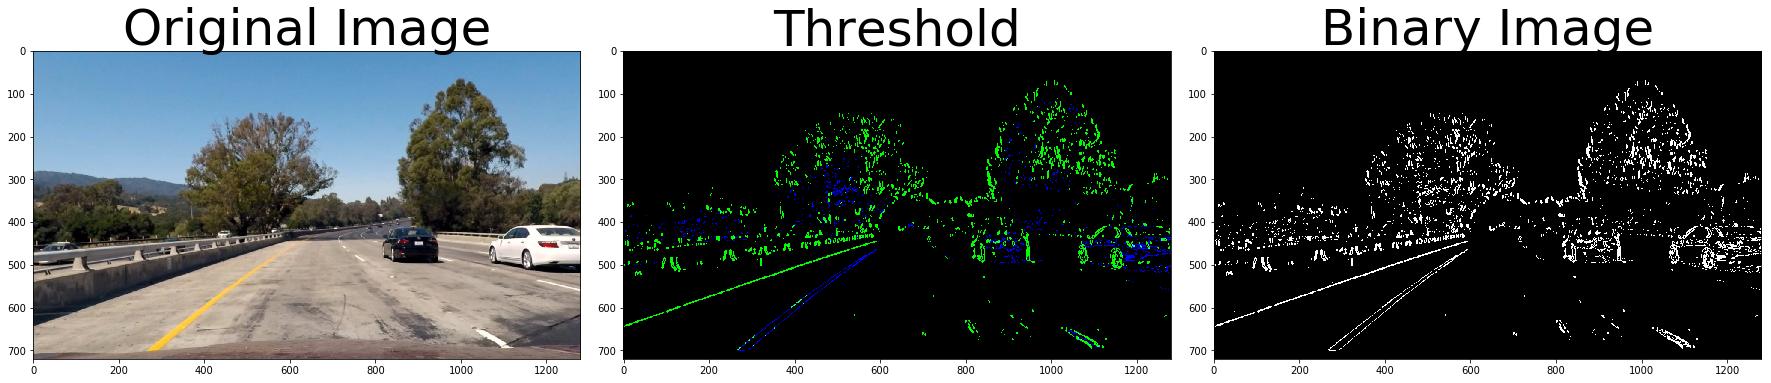

In [6]:

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('./test_images/test1.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

img_blur = gaussian_blur(image[:,:,0],9)

s_thresh=(150, 210)
sx_thresh=(40, 150)

# 1) Convert to HLS color space
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
# 2) Apply a threshold to the S channel
s_channel = hls[:,:,2]

sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

# Threshold color channel
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
# Stack each channel
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
#Convert to binary, I just used and or operator
binary_thresh = np.uint8((s_binary == 1) | (sxbinary == 1))

warped_img = warp(binary_thresh,roi)


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_binary, cmap='gray')
ax2.set_title('Threshold', fontsize=50)
ax3.imshow(binary_thresh, cmap='gray')
ax3.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Find Curvature

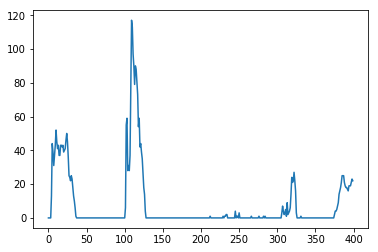

In [7]:
#First step, calculate histogram of white pixels
undist_test = cv2.undistort(image, mtx, dist, None, mtx)
thresh_img = thresholding(undist_test)
warped_img = warp(thresh_img,roi)
binary_warp = warped_img

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    h,w =img.shape
    bottom_half = img[h//2:,:]
    # TSum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# Create histogram of image binary activations
histogram = hist(binary_warp)

# Visualize the resulting histogram
plt.plot(histogram)

## Fit Polynomial

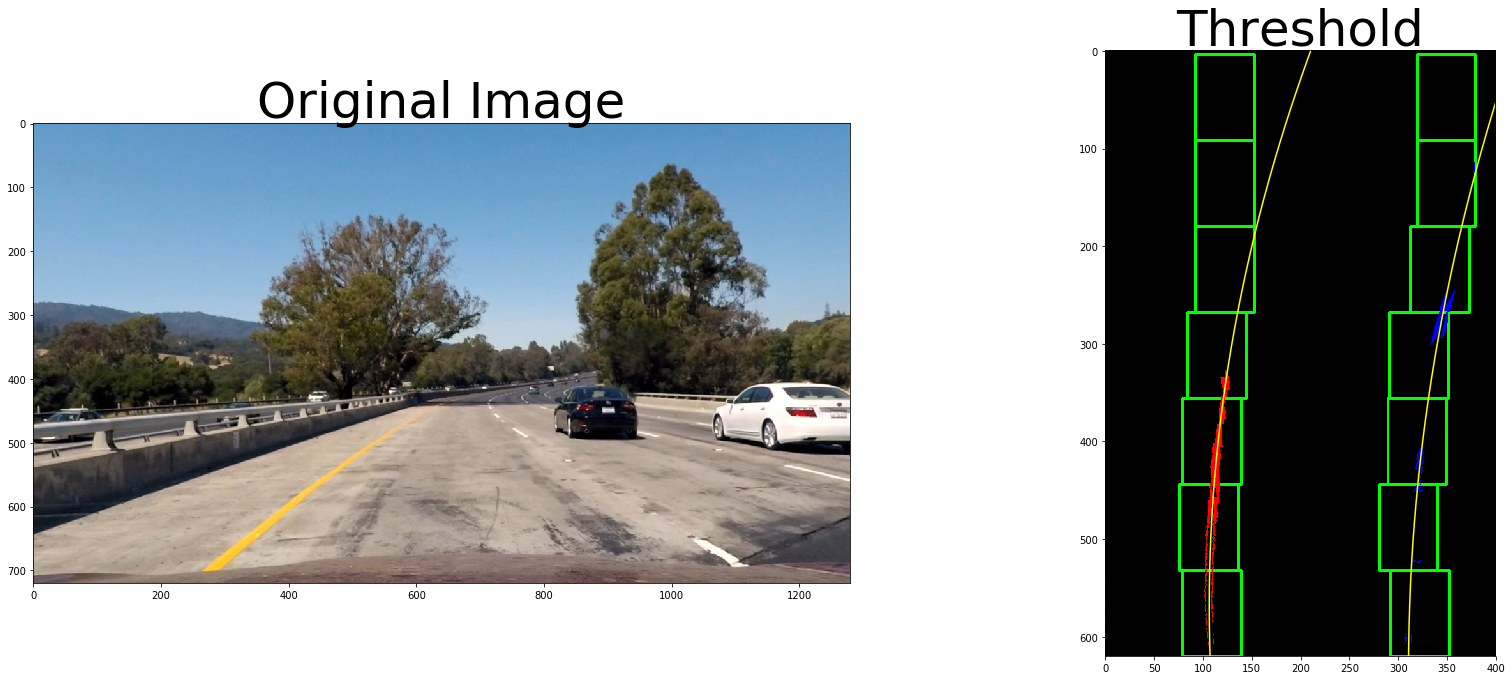

In [8]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/620 # meters per pixel in y dimension
xm_per_pix = 4.5/400 # meters per pixel in x dimension

#Windows lane
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 7
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty, rightx,2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    l_fit = np.poly1d(left_fit)
    r_fit = np.poly1d(right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = l_fit(ploty)
    right_fitx = r_fit(ploty)
    return left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, l_fit, r_fit

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warp)
left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, l_fit, r_fit = fit_poly(binary_warp.shape, leftx, lefty, rightx, righty)


## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warp, cmap='gray')
ax2.set_title('Threshold', fontsize=50)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.imshow(out_img)


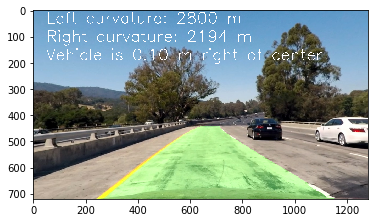

In [9]:
#Set badge of images
def calculate_curverad(line_fit_m, y_max):
    return ((1 + (2*line_fit_m[0]*y_max + line_fit_m[1])**2)**1.5) / np.absolute(2*line_fit_m[0])

def get_distance(lefty,righty,left_fit_m,right_fit_m,img_shape):
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)
    
    left_curverad = calculate_curverad(left_fit_m, y_eval_left)
    right_curverad = calculate_curverad(right_fit_m, y_eval_right)
    
    # Calculate vehicle center
    xMax = img_shape[1]*xm_per_pix
    yMax = img_shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return left_curverad,right_curverad,diffFromVehicle

def draw_area(undist_test,left_fitx, right_fitx, ploty, left_curverad, right_curverad, diffFromVehicle):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([400+left_fitx, 100+ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([400+right_fitx, 100+ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    src=np.float32([
        [696,455],
        [1038,675],
        [280,675],
        [588,455]])

    dst=np.float32([
        [700,350],
        [700,700],
        [500,700],
        [500,350]])

    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_test, 1, newwarp, 0.3, 0)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale=2
    fontColor = (255, 255, 255)
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)

    return result

def pipeline_process(img_video):
    undist_test = cv2.undistort(img_video, mtx, dist, None, mtx)
    binary_img = thresholding(undist_test)
    binary_warp = warp(binary_img,roi)
    img_shape =  binary_warp.shape
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warp)
    left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, l_fit, r_fit = fit_poly(img_shape, leftx, lefty, rightx, righty)
    left_curverad,right_curverad,diffFromVehicle = get_distance(lefty,righty,left_fit_m,right_fit_m,img_shape)
    out_img = draw_area(undist_test,left_fitx, right_fitx, ploty, left_curverad, right_curverad, diffFromVehicle)
    return out_img

image_validation = pipeline_process(image)
cv2.imwrite('./examples/image_validation.jpg',cv2.cvtColor(image_validation,cv2.COLOR_RGB2BGR))

plt.imshow(image_validation)

In [10]:
def search_around_poly(binary_warped,l_fit_pervious,r_fit_pervious):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (l_fit_pervious(nonzeroy) - margin)) & (nonzerox < (l_fit_pervious(nonzeroy) + margin)))
    right_lane_inds = ((nonzerox > (r_fit_pervious(nonzeroy) - margin)) & (nonzerox < (r_fit_pervious(nonzeroy) + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_m, right_fit_m,l_fit, r_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return lefty,righty, left_fitx, right_fitx, ploty, left_fit_m, right_fit_m,l_fit, r_fit

## Test Search around poly

In [11]:
#Set badge
PATH = './test_images/Video1/'
l_fit_pervious=[]
r_fit_pervious=[]

for i in range(255,280):
    img = mpimg.imread(PATH+'video1_{0}.jpg'.format(i))
    undist_test = cv2.undistort(img, mtx, dist, None, mtx)
    binary_img = thresholding(undist_test)
    binary_warp = warp(binary_img,roi)
    img_shape =  binary_warp.shape
    if (len(l_fit_pervious) == 0) or (len(r_fit_pervious) == 0):
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warp)
        l_fit_pervious, r_fit_pervious, ploty, left_fit_m, right_fit_m,l_fit, r_fit = fit_poly(img_shape, leftx, lefty, rightx, righty)
    else:
        lefty,righty, l_fit_pervious, r_fit_pervious, ploty, left_fit_m, right_fit_m,l_fit, r_fit = search_around_poly(binary_warp,l_fit,r_fit)
    left_curverad,right_curverad,diffFromVehicle = get_distance(lefty,righty,left_fit_m,right_fit_m,img_shape)
    out_img = draw_area(undist_test,l_fit_pervious, r_fit_pervious, ploty, left_curverad, right_curverad, diffFromVehicle)
    
    cv2.imwrite('out_{0}.jpg'.format(i),cv2.cvtColor(out_img,cv2.COLOR_RGB2BGR))
    
    

# Video PipeLine so far

In [12]:
class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.left_curverad = None
        self.right_curverad = None

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [127]:
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    lane = Lane()
    def pipeline_process(img_video):
        undist_test = cv2.undistort(img_video, mtx, dist, None, mtx)
        binary_img = thresholding(undist_test)
        binary_warp = warp(binary_img,roi)
        img_shape =  binary_warp.shape
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warp)
        left_fit, right_fit, ploty, left_fit_m, right_fit_m,_,_ = fit_poly(img_shape, leftx, lefty, rightx, righty)
        left_curverad,right_curverad,diffFromVehicle = get_distance(lefty,righty,left_fit_m,right_fit_m,img_shape)

        if left_curverad > 10000:
            left_fit = lane.left_fit
            left_fit_m = lane.left_fit_m
            left_curverad = lane.left_curverad
        else:
            lane.left_fit = left_fit
            lane.left_fit_m = left_fit_m
            lane.left_curverad = left_curverad

        if right_curverad > 10000:
            right_fit = lane.right_fit
            right_fit_m = lane.right_fit_m
            right_curverad = lane.right_curverad
        else:
            lane.right_fit = right_fit
            lane.right_fit_m = right_fit_m
            lane.right_curverad = right_curverad

        out_img = draw_area(undist_test,left_fit, right_fit, ploty, left_curverad, right_curverad, diffFromVehicle)

        return out_img
    
    clip = myclip.fl_image(pipeline_process)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'output_images/out1.mp4')

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/out1.mp4.
Moviepy - Writing video output_images/out1.mp4




t:  39%|███▉      | 491/1260 [00:41<01:07, 11.45it/s, now=None]


t:  76%|███████▋  | 963/1260 [01:23<00:34,  8.61it/s, now=None]


t:  39%|███▉      | 49/125 [3:50:18<00:06, 12.65it/s, now=None] 

Moviepy - Done !
Moviepy - video ready output_images/out1.mp4
